In [3]:
import fastq as fq
import pandas as pd
from Bio.Seq import Seq
from Bio import SeqIO
import os
import gzip
import zipfile
import shutil
import codecs
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import plotly 
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go

In [ ]:
#transfer files
scp -r /Users/Anna/Downloads/200k_barkodes/BC10_gz cyzt-0X0vLCNRpOjPrqTfi2Lw.DRQiECItHzUSAEQpWhAKEllKR3ZRBCUmIiceJkQzCx44CUdbIw@ssh.cyolo.io:/home/AnnaMalkova/b10

In [ ]:
# unzip
gunzip /home/AnnaMalkova/b10/BC10_gz/*.fq.gz

In [ ]:
# combine for rv separatedly
cat *_1.fq > frw.fastq
cat *_2.fq > rv.fastq

In [ ]:
# make complement reverse (not necessary)
seqtk seq -r rv.fastq > rv_rev.fastq

In [ ]:
# combibne all files
cat frw.fastq rv_rev.fastq > combined.fastq

In [ ]:
# delete the badly trimmed beginnig of reads
sed -E 's/.*(.{6}GATTTTTGA.*)/\1/' combined.fastq > clean.fastq

In [ ]:
# split on samples with new adaptors: 6 last ntd+known seq
nohup cat clean.fastq | fastx_barcode_splitter.pl --bcfile new_adaptors.tsv --bol --mismatches 1 --prefix /home/AnnaMalkova/b10/split/bla_new/bla_ --suffix ".txt" &

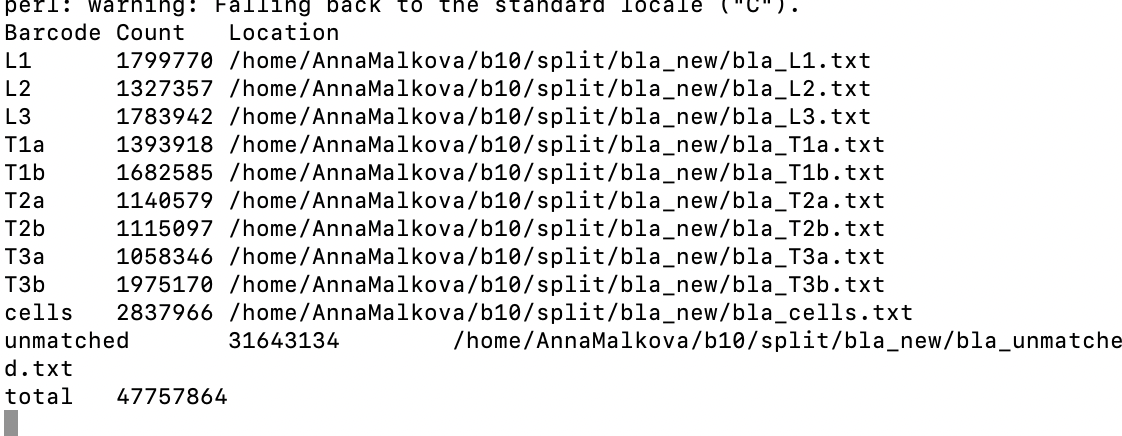

In [ ]:
#transfer
scp -r cyzt-XDgIH11HRXi6Ct42Wjsyw.DTwETDErWlMjAwUcWhAKEllKL2oGOyFUXT08MUdVOhtYXXkDHA@ssh.cyolo.io:/home/AnnaMalkova/b10/split/bla_new /Users/Anna/Downloads/200k_barkodes/BC10/bla_files/samples

In [5]:
def check(seq):
    list = ['TTACACCG', 'TCCTGGTA', 'GTCGAGAT', 'CTTGTCAC']
    f = {}
    for el in list:
        a = seq.count(el)
        f[el]=a
    return f

In [6]:
# check for the number of barcodes before processing
path = '/Users/Anna/Downloads/200k_barkodes/BC10/bla_files/samples/bla_new'
exp=[]
for filename in os.listdir(path):
    file_path = os.path.join(path, filename)
    encoding = 'latin-1'
    with codecs.open(file_path, 'r', encoding=encoding) as file:
        seq = file.read()
    quan = check(seq)
    exp.append(quan)
exp

[{'TTACACCG': 58, 'TCCTGGTA': 635, 'GTCGAGAT': 2759216, 'CTTGTCAC': 720},
 {'TTACACCG': 7, 'TCCTGGTA': 252, 'GTCGAGAT': 1022682, 'CTTGTCAC': 252},
 {'TTACACCG': 26, 'TCCTGGTA': 464, 'GTCGAGAT': 1907403, 'CTTGTCAC': 643},
 {'TTACACCG': 34, 'TCCTGGTA': 499, 'GTCGAGAT': 1709295, 'CTTGTCAC': 579},
 {'TTACACCG': 20, 'TCCTGGTA': 301, 'GTCGAGAT': 1081291, 'CTTGTCAC': 325},
 {'TTACACCG': 38, 'TCCTGGTA': 407, 'GTCGAGAT': 1723172, 'CTTGTCAC': 599},
 {'TTACACCG': 29, 'TCCTGGTA': 280, 'GTCGAGAT': 1265349, 'CTTGTCAC': 388},
 {'TTACACCG': 15, 'TCCTGGTA': 251, 'GTCGAGAT': 1103011, 'CTTGTCAC': 350},
 {'TTACACCG': 38, 'TCCTGGTA': 347, 'GTCGAGAT': 1348567, 'CTTGTCAC': 352},
 {'TTACACCG': 35, 'TCCTGGTA': 357, 'GTCGAGAT': 1626750, 'CTTGTCAC': 483}]

In [10]:
#extraction of sequence
def get_seq(path):
    encoding = 'latin-1'
    with codecs.open(path, 'r', encoding=encoding) as file:
        seq = file.read()
    split = seq.split('\n')
    clean_seq = split[1::4]
    clean_seq = ''.join(clean_seq)
    return clean_seq

In [72]:
#check of the function 'get_seq()'
with codecs.open('/Users/Anna/Downloads/200k_barkodes/BC10/bla_files/samples/bla_new/bla_T3a.txt', 'r', encoding=encoding) as file:
    seq = file.read()
print(seq[:200])
t3a = get_seq('/Users/Anna/Downloads/200k_barkodes/BC10/bla_files/samples/bla_new/bla_T3a.txt')
print(t3a.count('GTCGAGAT'))
cells = get_seq('/Users/Anna/Downloads/200k_barkodes/BC10/bla_files/samples/bla_new/bla_cells.txt')
print(cells.count('GTCGAGAT'))

'@V350144960L1C001R00100024609/1\nTACCTCGATTTTTGACCTCCATAGAAGATTCTAGAGTCGAGATGTTGCCAGGAGACTATACCGTGGTGCATGTGGGGACGAATTCGAATTTAAATCGGA\n+\nIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'

In [51]:
#extraction of sequence for all files
path = '/Users/Anna/Downloads/200k_barkodes/BC10/bla_files/samples/bla_new'
out = '/Users/Anna/Downloads/200k_barkodes/BC10/bla_files/clean'
for filename in os.listdir(path):
    file_path = os.path.join(path, filename)
    sq = get_seq(file_path)
    output_file_path = os.path.join(out, filename)
    with open(output_file_path, 'w') as output_file:
        output_file.write(sq)

In [52]:
# extraction of barcodes
import pandas as pd
def extract_barcodes(sample):
    barcodes = ['TTACACCG', 'TCCTGGTA', 'GTCGAGAT', 'CTTGTCAC']
    list = []
    for i in range(len(sample)):
        if sample[i:i+8] in barcodes:
            b1 = sample[i:i+8]
            b2 = sample[i+28:i+42]
            c = [b1,b2]
            list.append(c)
    sample_df = pd.DataFrame(list, columns=['b1', 'b2'])
    return sample_df

In [ ]:
#it took too much time 
df = pd.DataFrame(columns=['sample','b1', 'b2'])
path = '/Users/Anna/Downloads/200k_barkodes/BC10/bla_files/clean'
for filename in os.listdir(path):
    file_path = os.path.join(path, filename)
    encoding = 'latin-1'
    with codecs.open(file_path, 'r', encoding=encoding) as file:
        seq = file.read()
    filename_df = extract_barcodes(seq)
    filename_df['sample'] = filename
    df = pd.concat([df, filename_df], axis=0)

In [55]:
# takes 4 s
df_list = []
path = '/Users/Anna/Downloads/200k_barkodes/BC10/bla_files/clean'
for filename in os.listdir(path):
    file_path = os.path.join(path, filename)
    encoding = 'latin-1'
    with codecs.open(file_path, 'r', encoding=encoding) as file:
        seq = file.read()
    filename_df = extract_barcodes(seq)
    filename_df['sample'] = filename
    df_list.append(filename_df)

df = pd.concat(df_list, axis=0)

In [56]:
df

b1              b2         sample
0      GTCGAGAT  TGTGGTTCGCGTCA  bla_cells.txt
1      GTCGAGAT  CTTTATGTACCGGG  bla_cells.txt
2      GTCGAGAT  TCTAGCTGTGTTGT  bla_cells.txt
3      GTCGAGAT  GCTCATGTACGATT  bla_cells.txt
4      GTCGAGAT  CCCGTATGTGTTAC  bla_cells.txt
...         ...             ...            ...
20564  GTCGAGAT  TGTTGTAGGCTAAC    bla_T1b.txt
20565  GTCGAGAT  GTAACGAGAGTTTA    bla_T1b.txt
20566  GTCGAGAT  CGGGTGCAGCGTTG    bla_T1b.txt
20567  GTCGAGAT  CCTGATACTCCGGC    bla_T1b.txt
20568  GTCGAGAT        GTGCGTTG    bla_T1b.txt

[196763 rows x 3 columns]

In [57]:
#save the raw df
df.to_csv('/Users/Anna/Downloads/200k_barkodes/BC10/all_barcodes_function.csv')

In [58]:
# add info about barcodes
barcodes_200k = pd.read_excel('/Users/Anna/Downloads/200k_barkodes/barcodes 200k.xlsx')
barcodes_200k
spec_bars = barcodes_200k[(barcodes_200k['barcode']=='BAR2')|
                          (barcodes_200k['barcode']=='BAR3')|
                          (barcodes_200k['barcode']=='BAR5')|
                          (barcodes_200k['barcode']=='BAR22')]
spec_bars = spec_bars.rename(columns={'seq': 'b1'})


for el in spec_bars['barcode']:
    if el == 'BAR2':
        spec_bars.loc[spec_bars['barcode'] == el, 'bag_mod'] = 'wt'
    elif el == 'BAR3':
        spec_bars.loc[spec_bars['barcode'] == el, 'bag_mod'] = 'delta w'
    elif el == 'BAR5':
        spec_bars.loc[spec_bars['barcode'] == el, 'bag_mod'] = 'delta'
    elif el == 'BAR22':
        spec_bars.loc[spec_bars['barcode'] == el, 'bag_mod'] = 'fl'

        
spec_bars

barcode        b1  bag_mod
1     BAR2  TTACACCG       wt
2     BAR3  TCCTGGTA  delta w
4     BAR5  GTCGAGAT    delta
21   BAR22  CTTGTCAC       fl

In [59]:
df_full = df.merge(right=spec_bars, how='outer', on='b1')
df_full

b1              b2         sample barcode bag_mod
0       GTCGAGAT  TGTGGTTCGCGTCA  bla_cells.txt    BAR5   delta
1       GTCGAGAT  CTTTATGTACCGGG  bla_cells.txt    BAR5   delta
2       GTCGAGAT  TCTAGCTGTGTTGT  bla_cells.txt    BAR5   delta
3       GTCGAGAT  GCTCATGTACGATT  bla_cells.txt    BAR5   delta
4       GTCGAGAT  CCCGTATGTGTTAC  bla_cells.txt    BAR5   delta
...          ...             ...            ...     ...     ...
196758  CTTGTCAC  TCGATTTTTGACCT    bla_T1b.txt   BAR22      fl
196759  CTTGTCAC  ATTTTTGACCTCCA    bla_T1b.txt   BAR22      fl
196760  TTACACCG  AAGATTCTAGAGTC    bla_T3b.txt    BAR2      wt
196761  TTACACCG  CGATGATTTTTGAC    bla_T3b.txt    BAR2      wt
196762  TTACACCG  GTTCGATTTTTGAC     bla_L3.txt    BAR2      wt

[196763 rows x 5 columns]

In [60]:
df_full.to_csv('/Users/Anna/Downloads/200k_barkodes/BC10/all_barcodes_bag.csv')

In [7]:
df_full = pd.read_csv('/Users/Anna/Downloads/200k_barkodes/BC10/all_barcodes_function.csv')

In [61]:
df_combined = df_full.copy()

In [62]:
df_combined['sample'] = df_combined['sample'].apply(lambda x: x.replace('.txt',''))
df_combined['sample'] = df_combined['sample'].apply(lambda x: x.replace('bla_',''))
df_combined['sample'].value_counts()

sample
cells    34575
T3b      24696
L1       21620
L3       21587
T1b      20569
T1a      17142
L2       16347
T2a      13654
T2b      13562
T3a      13011
Name: count, dtype: int64

In [63]:
#change the names of samples
df_combined['sample'] = df_combined['sample'].apply(lambda x: 'mouse1_mts' if 'L1' in x else x)
df_combined['sample'] = df_combined['sample'].apply(lambda x: 'mouse2_mts' if 'L2' in x else x)
df_combined['sample'] = df_combined['sample'].apply(lambda x: 'mouse3_mts' if 'L3' in x else x)
df_combined['sample'] = df_combined['sample'].apply(lambda x: 'mouse1_tumor' if x in ['T1a', 'T1b'] else x)
df_combined['sample'] = df_combined['sample'].apply(lambda x: 'mouse2_tumor' if x in ['T2a', 'T2b'] else x)
df_combined['sample'] = df_combined['sample'].apply(lambda x: 'mouse3_tumor' if x in ['T3a', 'T3b'] else x)

In [65]:
samples=df_combined['sample'].value_counts()
samples

sample
mouse1_tumor    37711
mouse3_tumor    37707
cells           34575
mouse2_tumor    27216
mouse1_mts      21620
mouse3_mts      21587
mouse2_mts      16347
Name: count, dtype: int64

In [66]:
fig = px.histogram(df_combined,
             x='sample',
             color='bag_mod',
             barmode="group", category_orders={"sample": sorted(df_combined["sample"].unique())})
fig.show()

In [13]:
df_combined.to_csv('/Users/Anna/Downloads/200k_barkodes/BC10/df_combined.csv')

In [14]:
# Analysis of barcodes 1
b1_count = df_combined.groupby('sample', as_index=False)['bag_mod'].value_counts()
b1_count

sample  bag_mod    count
0          cells    delta  2759312
1          cells       fl      720
2          cells  delta w      655
3          cells       wt       58
4     mouse1_mts    delta  1709296
5     mouse1_mts       fl      579
6     mouse1_mts  delta w      499
7     mouse1_mts       wt       40
8   mouse1_tumor    delta  2975502
9   mouse1_tumor       fl      835
10  mouse1_tumor  delta w      726
11  mouse1_tumor       wt       73
12    mouse2_mts    delta  1265433
13    mouse2_mts       fl      388
14    mouse2_mts  delta w      312
15    mouse2_mts       wt       29
16  mouse2_tumor    delta  2184305
17  mouse2_tumor       fl      683
18  mouse2_tumor  delta w      572
19  mouse2_tumor       wt       35
20    mouse3_mts    delta  1723173
21    mouse3_mts       fl      600
22    mouse3_mts  delta w      435
23    mouse3_mts       wt       38
24  mouse3_tumor    delta  2930685
25  mouse3_tumor  delta w      964
26  mouse3_tumor       fl      897
27  mouse3_tumor       wt       43

In [42]:
count_df = df_combined.groupby(['bag_mod', 'b2']).size().reset_index(name='count')
count_df

bag_mod              b2  count
0         delta  000218732/1ATG      1
1         delta  000379999/1TGG      1
2         delta  001308045/2TGG      1
3         delta  002R0190001608      1
4         delta  00901187176/2A      1
...         ...             ...    ...
1156306      wt  TTTGACCTCCAAAG      1
1156307      wt  TTTGACCTCCACAG      1
1156308      wt  TTTGACCTCCATAG      7
1156309      wt  TTTGAGATCAATGT      6
1156310      wt  TTTTTGACCTCCAT      5

[1156311 rows x 3 columns]

In [38]:
fig = px.box(b1_count,
             y='count')
fig.show()

In [15]:
fig = px.bar(b1_count,
             x='sample',y='count',
             color='bag_mod',
             barmode="group")
fig.show()

In [30]:
#Distribution of different cell lines in samples
fig = make_subplots(
    rows=4, cols=2,
    vertical_spacing=0.09,
    specs=[[{"type": "pie"}, {"type": "pie"}] ,
           [{"type": "pie"}       ,{"type": "pie"}] ,
           [{"type": "pie"}       ,{"type": "pie"}] ,
           [{"type": "pie"}       ,{"type": "pie"}] 
          ],
    subplot_titles=('<b>Cells<b>','<b><b>',
                    '<b>Mouse1 tumor<b>','<b>Mouse1 mts<b>',
                    '<b>Mouse2 tumor<b>', '<b>Mouse2 mts<b>',
                    '<b>Mouse3 tumor<b>', '<b>Mouse3 mts<b>')
)
fig.add_trace(
    go.Pie(values=df_combined[df_combined['sample']=='cells']['bag_mod'].value_counts(normalize=True).values,
           labels=['<b>delta<b>','<b>delta w<b>','<b>full lengh<b>', '<b>wild type<b>'],
           hole=0.3,pull=[0,0.08,0.3],
           marker_colors=['pink','lightblue','lightgreen', 'lightsalmon'],
           textposition='inside'),
    row=1, col=1
)

fig.add_trace(
    go.Pie(values=df_combined[df_combined['sample']=='mouse1_tumor']['bag_mod'].value_counts(normalize=True).values,
           labels=['<b>delta<b>','<b>delta w<b>','<b>full lengh<b>', '<b>wild type<b>'],
           hole=0.3,pull=[0,0.08,0.3],
           marker_colors=['pink','lightblue','lightgreen', 'lightsalmon'],
           textposition='inside'),
    row=2, col=1
)

fig.add_trace(
    go.Pie(values=df_combined[df_combined['sample']=='mouse1_mts']['bag_mod'].value_counts(normalize=True).values,
           labels=['<b>delta<b>','<b>delta w<b>','<b>full lengh<b>', '<b>wild type<b>'],
           hole=0.3,pull=[0,0.08,0.3],
           marker_colors=['pink','lightblue','lightgreen', 'lightsalmon'],
           textposition='inside'),
    row=2, col=2
)

fig.add_trace(
    go.Pie(values=df_combined[df_combined['sample']=='mouse2_tumor']['bag_mod'].value_counts(normalize=True).values,
           labels=['<b>delta<b>','<b>delta w<b>','<b>full lengh<b>', '<b>wild type<b>'],
           hole=0.3,pull=[0,0.08,0.3],
           marker_colors=['pink','lightblue','lightgreen', 'lightsalmon'],
           textposition='inside'),
    row=3, col=1
)

fig.add_trace(
    go.Pie(values=df_combined[df_combined['sample']=='mouse2_mts']['bag_mod'].value_counts(normalize=True).values,
           labels=['<b>delta<b>','<b>delta w<b>','<b>full lengh<b>', '<b>wild type<b>'],
           hole=0.3,pull=[0,0.08,0.3],
           marker_colors=['pink','lightblue','lightgreen', 'lightsalmon'],
           textposition='inside'),
    row=3, col=2
)

fig.add_trace(
    go.Pie(values=df_combined[df_combined['sample']=='mouse3_tumor']['bag_mod'].value_counts(normalize=True).values,
           labels=['<b>delta<b>','<b>delta w<b>','<b>full lengh<b>', '<b>wild type<b>'],
           hole=0.3,pull=[0,0.08,0.3],
           marker_colors=['pink','lightblue','lightgreen', 'lightsalmon'],
           textposition='inside'),
    row=4, col=1
)

fig.add_trace(
    go.Pie(values=df_combined[df_combined['sample']=='mouse3_mts']['bag_mod'].value_counts(normalize=True).values,
           labels=['<b>delta<b>','<b>delta w<b>','<b>full lengh<b>', '<b>wild type<b>'],
           hole=0.3,pull=[0,0.08,0.3],
           marker_colors=['pink','lightblue','lightgreen', 'lightsalmon'],
           textposition='inside'),
    row=4, col=2
)

fig.update_layout(
    height=800,
    showlegend=True,
    title_text="<b>Distribution of cell with different BAG modification in samples<b>",
)

fig.show()

In [20]:
# Analysis of random barcodes 2
count_b2 = df_combined.groupby(['sample', 'bag_mod'], as_index=False)['b2'].value_counts()
count_b2 = count_b2[count_b2['sample']!= 'cells']
count_b2

sample bag_mod              b2  count
244249     mouse1_mts   delta  TGTTGTAGGCTAAC  66900
244250     mouse1_mts   delta  TTTTTCCAGTGGCC  22781
244251     mouse1_mts   delta  TGTTGGGGAGATTT  21461
244252     mouse1_mts   delta  TTTAGATGAGCTAG  20011
244253     mouse1_mts   delta  TTGCTGCGTCCAGT  12822
...               ...     ...             ...    ...
1711688  mouse3_tumor      wt  AAGATTCCAGAGTC      1
1711689  mouse3_tumor      wt  ATAGAAGATTCTAG      1
1711690  mouse3_tumor      wt  ACCTCCATAGAAGA      1
1711691  mouse3_tumor      wt  AAGGTTCTAGAGTC      1
1711692  mouse3_tumor      wt  TTTGACCTCCATAG      1

[1467444 rows x 4 columns]

In [21]:
mouse1_tumor = count_b2[count_b2['sample'] == 'mouse1_tumor']
mouse1_mts = count_b2[count_b2['sample'] == 'mouse1_mts']
mouse1_tumor['x'] = range(len(mouse1_tumor))
mouse1_mts['x'] = range(len(mouse1_mts))
mouse1_all = pd.concat([mouse1_tumor, mouse1_mts], axis=0)


/var/folders/f8/q9zbymw9785b7wb9qx0sclfw0000gn/T/ipykernel_47272/210970883.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/f8/q9zbymw9785b7wb9qx0sclfw0000gn/T/ipykernel_47272/210970883.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [22]:
mouse1_all

sample bag_mod              b2   count       x
447864  mouse1_tumor   delta  TGTTGTAGGCTAAC  122298       0
447865  mouse1_tumor   delta  TTTTTCCAGTGGCC   42653       1
447866  mouse1_tumor   delta  TGTTGGGGAGATTT   41026       2
447867  mouse1_tumor   delta  TTTAGATGAGCTAG   35572       3
447868  mouse1_tumor   delta  TTGCTGCGTCCAGT   23073       4
...              ...     ...             ...     ...     ...
447859    mouse1_mts      wt  TCGAATTTAAGAAC       1  203610
447860    mouse1_mts      wt  TCGGAACACGATTT       1  203611
447861    mouse1_mts      wt  TCGGATGAACACGA       1  203612
447862    mouse1_mts      wt  TGGGAACACGATTT       1  203613
447863    mouse1_mts      wt  TTTGACCTCCATAG       1  203614

[504039 rows x 5 columns]

In [23]:
fig = px.line(mouse1_all[mouse1_all['x']<100],
              y='count',
              x='x',
              color='sample',
              labels = {'count':'random barcode count',
                        'x': 'random barcode'}
)
fig.show()

In [24]:
mouse2_tumor = count_b2[count_b2['sample'] == 'mouse2_tumor']
mouse2_mts = count_b2[count_b2['sample'] == 'mouse2_mts']
mouse2_tumor['x'] = range(len(mouse2_tumor))
mouse2_mts['x'] = range(len(mouse2_mts))
mouse2_all = pd.concat([mouse2_tumor, mouse2_mts], axis=0)

fig = px.line(mouse2_all[mouse2_all['x']<100],
              y='count',
              x='x',
              color='sample',
              labels = {'count':'random barcode count',
                        'x': 'random barcode'}
)
fig.show()

/var/folders/f8/q9zbymw9785b7wb9qx0sclfw0000gn/T/ipykernel_47272/3440450400.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/f8/q9zbymw9785b7wb9qx0sclfw0000gn/T/ipykernel_47272/3440450400.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [25]:
mouse3_tumor = count_b2[count_b2['sample'] == 'mouse3_tumor']
mouse3_mts = count_b2[count_b2['sample'] == 'mouse3_mts']
mouse3_tumor['x'] = range(len(mouse3_tumor))
mouse3_mts['x'] = range(len(mouse3_mts))
mouse3_all = pd.concat([mouse3_tumor, mouse3_mts], axis=0)

fig = px.line(mouse3_all[mouse3_all['x']<100],
              y='count',
              x='x',
              color='sample',
              labels = {'count':'random barcode count',
                        'x': 'random barcode'}
)
fig.show()

/var/folders/f8/q9zbymw9785b7wb9qx0sclfw0000gn/T/ipykernel_47272/1908527790.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/f8/q9zbymw9785b7wb9qx0sclfw0000gn/T/ipykernel_47272/1908527790.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

